# Restricted Boltzmann Machine (RBM)

In this note, I show how Restricted Boltzmann Machine (RBM) works to make a simple movie recommendation system based on customers' evaluation to the ones they watched. This model outputs binary prediction (weather or not cusomers would like the movies they have not watched). A concise detail of the algorithm is at 'An Introduction
to Restricted Boltzmann Machines' https://pdfs.semanticscholar.org/dd13/5a89b5075af5cbef5becaf419457cdd77cc9.pdf.

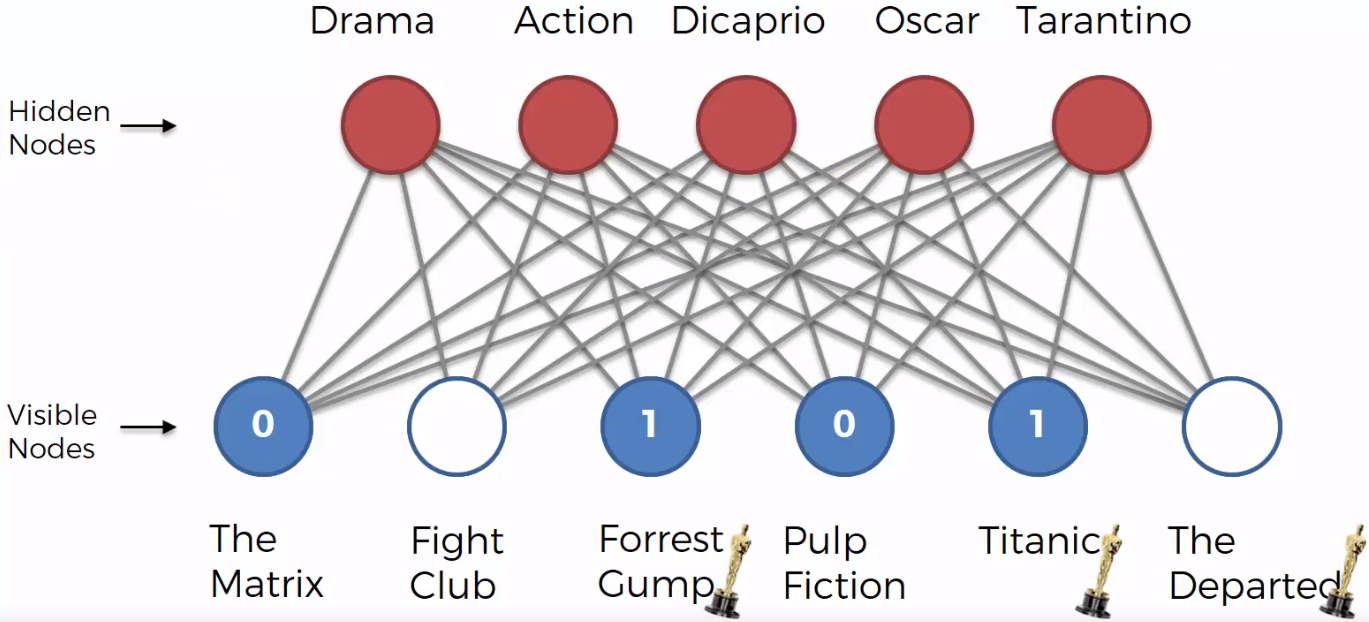

figure 1. intuitive image of RBM. source: https://www.youtube.com/watch?v=Jj8Vv4g1oQA, Deep Learning A-Z™: Hands-On Artificial Neural Networks


In [1]:
from IPython.display import Image, display_jpeg, display_png
display_png(Image('RBM2.PNG'))
print('figure 1. intuitive image of RBM. source: https://www.youtube.com/watch?v=Jj8Vv4g1oQA, Deep Learning A-Z™: Hands-On Artificial Neural Networks')

In the figure above, the hidden nodes are labeled as 'Drama', 'Action', 'Dicaprio', 'Oscar', 'Tarantino', but these are just for simplifying our understanding; The real RBM does not verbalize the features like this (just like the nodes in ANN). 

RBM updates the weights based on Gibbs Sampling. However, in actual RBM we adopt contrastive divergence 
(the detail of contrastive divergence is described at https://www.cs.toronto.edu/~hinton/absps/fastnc.pdf).

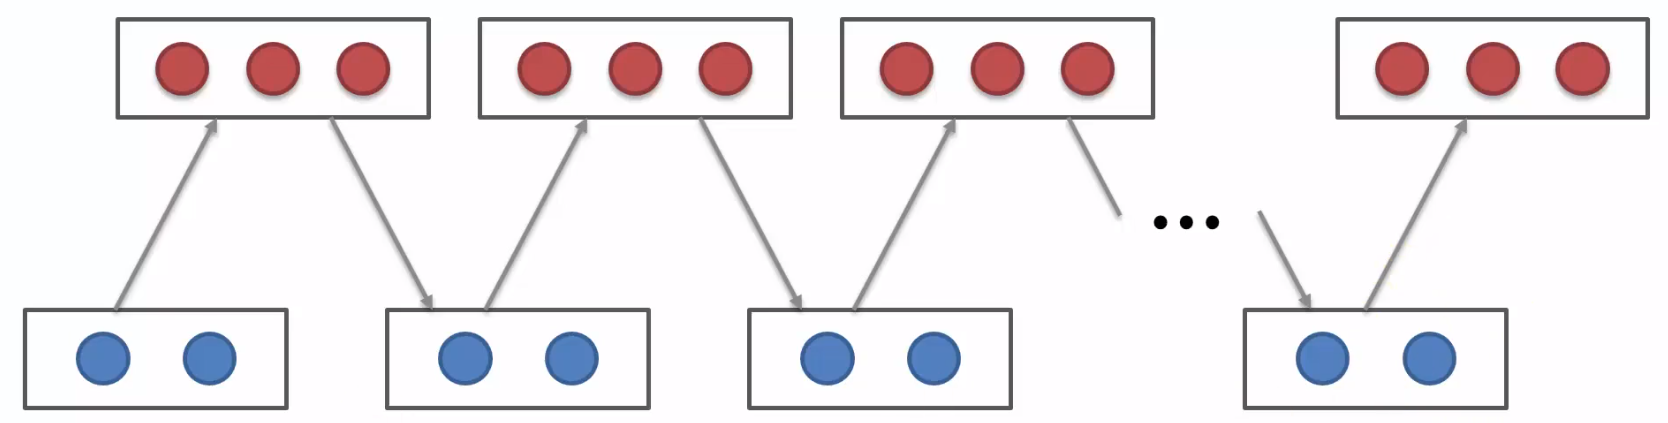

figure 2. How the input and hidden layers are updated


In [2]:
from IPython.display import Image, display_png
display_png(Image('gibbsSampling1.PNG'))
print('figure 2. How the input and hidden layers are updated')

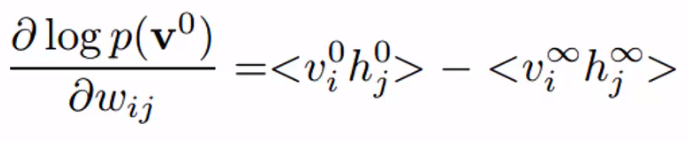

figure 3. the formula updating the weights. See 'A fast learning algorithm for deep belief nets ' https://www.cs.toronto.edu/~hinton/absps/fastnc.pdf or ' An Introduction to Restricted Boltzmann Machines ' https://pdfs.semanticscholar.org/dd13/5a89b5075af5cbef5becaf419457cdd77cc9.pdf  for more detail


In [3]:
from IPython.display import Image, display_png
display_png(Image('RBM3.PNG'))
print('figure 3. the formula updating the weights. See \'A fast learning algorithm for deep belief nets \' https://www.cs.toronto.edu/~hinton/absps/fastnc.pdf or \' An Introduction to Restricted Boltzmann Machines \' https://pdfs.semanticscholar.org/dd13/5a89b5075af5cbef5becaf419457cdd77cc9.pdf  for more detail')

## Data import

In [39]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
from torch.autograd import Variable
import myRbmClass

######### these datasets were imported just to easily understand the data structure ###############
#import the movie dataset
movies = pd.read_csv('ml-1m/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
#import the users dataset
users = pd.read_csv('ml-1m/users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
#import the ratings dataset
rating = pd.read_csv('ml-1m/ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
###################################################################################################

#import the training and test set
training_set = pd.read_csv('ml-100k/u1.base', delimiter = '\t', header = None)
#print("training_set ", training_set)
training_set_array = np.array(training_set, dtype = 'int')
#print("training_set_array ", training_set_array)
test_set = pd.read_csv('ml-100k/u1.test', delimiter = '\t', header = None)
test_set_array = np.array(training_set, dtype = 'int')

print('movies')
display(movies.head())
print('users')
display(users.head())
print('rating')
display(rating.head())
print('training_set: user id, movie id, rating, evaluation (1 to 5), timestamp (not used)')
display(training_set.head())
print('test_set: user id, movie id, rating, evaluation (1 to 5), timestamp (not used)')
display(test_set.head())

movies


,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


users


,0,1,2,3,4
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


rating


,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


training_set: user id, movie id, rating, evaluation (1 to 5), timestamp (not used)


,0,1,2,3
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


test_set: user id, movie id, rating, evaluation (1 to 5), timestamp (not used)


,0,1,2,3
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


## Preprocessing

In [25]:
#get the number of users and movies
nb_users = int(max(max(training_set_array[:, 0]), max(test_set_array[:, 0])))
print('nb_users:{}'.format(nb_users))
nb_movies = int(max(max(training_set_array[:, 1]), max(test_set_array[:, 1])))
print('nb_movies:{}'.format(nb_movies))

#convert the data into an 2d list (1st index = user id, 2nd indes = movie, elements = ratings)
# the rating where userd did not watach or evaluate was regarded as 0 (from ratings = np.zeros(nb_movies))
def convertArrayToList(data):
    new_data = []
    for userId in range(1, nb_users + 1):
#         pick up the movie id and the ratings only which were watched by each user 
        id_movies = data[:, 1][data[:, 0] == userId]
        id_ratings = data[:, 2][data[:, 0] == userId]
        ratings = np.zeros(nb_movies)
#         adjust the id_movies to the array index
        ratings[id_movies - 1] = id_ratings
#        print("ratings.shape:", ratings.shape)
#        print("ratings[id_movies - 1]:", ratings[id_movies - 1])
#        print("ratings:", ratings)
        new_data.append(list(ratings))
#        print('new_data: ',new_data)
    return new_data

training_set_list = convertArrayToList(training_set_array)
print("len(training_set_list):{}, len(training_set_list[0]):{}".format(len(training_set_list), len(training_set_list[0])))
test_set_list = convertArrayToList(test_set_array)
print('-------------------------------------------------')

#convert the data into torch tensors (a matrix of a single data type)
training_set_torchTensor = torch.FloatTensor(training_set_list)
print('training_set_torchTensor)
print(training_set_torchTensor)
test_set_torchTensor = torch.FloatTensor(test_set_list)

#convert the ratings into binary ratings 1 (liked) or 0 (not liked) for RBM format because the output value of RBM is binary
#no rating 0 -> -1
training_set_torchTensor[training_set_torchTensor == 0] = -1
training_set_torchTensor[training_set_torchTensor == 1] = 0
training_set_torchTensor[training_set_torchTensor == 2] = 0
training_set_torchTensor[training_set_torchTensor >= 3] = 1
test_set_torchTensor[test_set_torchTensor == 0] = -1
test_set_torchTensor[test_set_torchTensor == 1] = 0
test_set_torchTensor[test_set_torchTensor == 2] = 0
test_set_torchTensor[test_set_torchTensor >= 3] = 1

nb_users:943
nb_movies:1682
len(training_set_list):943, len(training_set_list[0]):1682
-------------------------------------------------
training_set_torchTensor

    5     3     4  ...      0     0     0
    4     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    5     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     5     0  ...      0     0     0
[torch.FloatTensor of size 943x1682]

training_set_torchTensor after torch.FloatTensor

    5     3     4  ...      0     0     0
    4     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    5     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     5     0  ...      0     0     0
[torch.FloatTensor of size 943x1682]



## define the architecture/object of the neural network

In [26]:
#number of movies == nv
nv = len(training_set_torchTensor[0])
print('nv:{}'.format(nv))
#the parameter we choose == nh (number of hidden node) == number of features detected by the RBM model
nh = 100
#the parameter we choose
batchSize = 10
#batchSize = 100

# myRbmClass.RBM is defined at the bottom of this note as Appendix.
rbm = myRbmClass.RBM(nv, nh)

nv:1682


## Train the model

In [ ]:
# number of epoch
nb_epoch = 10

for epoch in range(nb_epoch + 1):
#    loss function output
    train_loss = 0
#    counter for normalizing the train loss
    s = 0.0
#    loop for each user
    for id_user in range (0, nb_users - batchSize, batchSize):
#        input vector, which is gonna be updated by RBM
        vk = test_set_torchTensor[id_user : id_user + batchSize]
#        the target vector, which is NOT gonna be updated but compared with vk to calculate the loss
        v0 = test_set_torchTensor[id_user : id_user + batchSize]
#        initial probability setting
        ph0, _ = rbm.sample_hiddenNodes(v0) 
#        loop for k-steps contrastive divergence, (k-steps random walk Gibbs sampling == Marcov chain monte carlo technique)
        for k in range (10):
#            update the hidden node at k th step of contrasitve divergence
            _ , hk = rbm.sample_hiddenNodes(vk)
#            update the sampled visible node after the k th step of Gibbs sampling 
            _ , vk = rbm.sample_visibleNodes(hk)
#            the ratings of the movies that were not rated were all -1. we want to keep these ratings -1 (non rated)
            vk[v0 < 0] = v0[v0 < 0]
            
#        get phk (output variable from the hidden layer) for training
        phk, _ = rbm.sample_hiddenNodes(vk)
#        approximate the gradient to update the biases and the hidden node weights towards the direction of maximum likelihood
        rbm.train(v0, vk, ph0, phk)
#        update the train loss
        train_loss += torch.mean(torch.abs(v0[v0 >= 0] - vk[v0 >= 0]))
#        if you want to calc the loss function with RMSE (Root Mean Square Error), do like this
#        train_loss += np.sqrt(torch.mean((v0[v0>=0] - vk[v0>=0])**2))
  
        s += 1. 
#    we want to show the normalized train loss
    print('epoch: ' + str(epoch) + ' loss: ' + str(train_loss/s))


(you gonna get a result like this); Having around 0.25 means the model was train to be correct 3 times out of 4.

epoch: 0 loss: 0.27239755277267513  
epoch: 1 loss: 0.2533783499867402  
epoch: 2 loss: 0.24978804816456007  
epoch: 3 loss: 0.25089838668047765  
epoch: 4 loss: 0.25019855106514094  
epoch: 5 loss: 0.2505773111581701  
epoch: 6 loss: 0.2510438632214849  
epoch: 7 loss: 0.2505546126062868  
epoch: 8 loss: 0.24936035007851762  
epoch: 9 loss: 0.24933076700440227  
epoch: 10 loss: 0.24931042810884846  

## Test the model

In [34]:
test_loss = 0
s = 0.0

#    loop for each user
for id_user in range (0, nb_users):
#    you must not use test_set_torchTensor here
    v = training_set_torchTensor[id_user : id_user + 1]
#    you must use test_set_torchTensor only here
    vTarget = test_set_torchTensor[id_user : id_user + 1]
#    eliminate the user giving only -1 ratings (not rated movies)
    if len(vTarget[vTarget >= 0]) > 0:
        _ , h = rbm.sample_hiddenNodes(v)
        _ , v = rbm.sample_visibleNodes(h)
    #        update the test loss
        test_loss += torch.mean(torch.abs(vTarget[vTarget >= 0] - v[vTarget >= 0]))
        s += 1. 
#        if you want to calc the loss function with RMSE (Root Mean Square Error), do like this
#        test_loss += np.sqrt(torch.mean((vTarget[vTarget >= 0] - v[vTarget >= 0])**2))
                
print('test loss ' + str(test_loss/s))


test loss 0.2434771955514565


Since the train loss was close to the mean train loss, we can say there is no overfitting.

## Appendix: myRbmClass.py

In [11]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
from torch.autograd import Variable

class RBM():
    
    def __init__ (self, nv, nh):
        '''
        nv: number of visible nodes (the blue circles in figure 1 and 2)
        nh: number of hidden nodes (the red circles in figure 1 and 2)
        '''
#        weight: the probability of all hidden nodes
#        initialize all the weight, which is normalized. weight matrix of p_v_given_h 
        self.W = torch.randn(nh, nv)
#        bias for hidden nodes, which should be 2 dimentional.
        self.a = torch.randn(1, nh)
#        bias for visible node, which should be 2 dimentional.
        self.b = torch.randn(1, nv)

    def sample_hiddenNodes(self, x):
        '''
        x: verctor of visible neurons (nv)
        '''
#        weight (self.W) * nv, product of the two tensors
#        print("x:{}, self.W.t():{}".format(x, self.W.t()))
#        print("x.shape:{}, self.W.t().shape:{}".format(x.shape, self.W.t().shape))
        wx = torch.mm(x, self.W.t())

#        make sure the bias are applied to each line of mini-batch
        activation = wx + self.a.expand_as(wx)

#        probability of the activated hidden node give visible node
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)
        
    def sample_visibleNodes(self, y):
        '''
        y: verctor of hidden neurons (nh)
        '''
#        weight (self.W) * nh: product of the two tensors
        wy = torch.mm(y, self.W)
#        make sure the bias are applied to each line of mini-batch
        activation = wy + self.b.expand_as(wy)
#        probability of the activated hidden node give visible node
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)


#        contrastive divergence = approximation of log likelihood of gredianet
#        minimize the energy in energy function = maximizing the likelihood

    def train(self, v0, vk, ph0, phk):
        '''
        v0: the input vactor containing all the movie ratings by one user 
        vk: visible nodes obtained after k Gibbs samplings
        ph0: the vector of probabilities at the first iteration, the hidden nodes eaual 1 given v0, 
        phk:the probabilities of hidden node after k sampling given the visible node variables vk
        '''
        self.W += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk) 
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)